# Interrupts and Commands in LangGraph

This notebook demonstrates how to create human-in-the-loop workflows using LangGraph's `interrupt` and `Command` features. We'll build a workflow that pauses for user approval and dynamically routes based on the user's decision.

## Key Concepts

- **Interrupts**: Pause graph execution and wait for human input
- **Commands**: Dynamically control graph routing and execution flow
- **Checkpointing**: Required for interrupts to save and restore state

#### Interrupt

The Interrupt function in LangGraph is built to simplify the creation of human-in-the-loop agents by leveraging LangGraph's robust persistence layer.

1. **Approve or Reject Steps**

   - Interrupt allows humans to approve or reject LLM decisions (responses/function calls) and directs the graph to different nodes based on human input.

2. **Reviewing and Editing Graph State**

   - Humans can pause the graph to review and update its state (LLM responses, documents, intermediate values) before execution resumes.

3. **Reviewing and Approving Tool Calls**
   - Provides essential human oversight by allowing review of LLM-generated tool calls before execution.

#### Command

The Command type is a new feature in LangGraph designed to create more expressive and controllable communication between agents and nodes, allowing for dynamic control flow.

1. **Dynamic Routing within an Agent and Edgeless Graphs**

   - Command enables nodes to explicitly define next execution paths, deciding between tool nodes or run termination, supporting "edgeless graphs."

2. **Handoffs in Multi-Agent Setups**

   - Transfers control from one agent to another specialized agent, enabling layering where agents can act as nodes within larger agent architectures.

3. **Enhanced Communication and Control Flow**
   - Controls graph execution flow by allowing nodes to update state and dictate subsequent paths, supporting parallel updates and hierarchical architectures.

## Workflow Overview

Our workflow will:

1. Present a task for approval
2. Pause execution and wait for user decision
3. Route to completion or cancellation based on the decision


In [14]:
import os
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver
from IPython.display import Image, display
from rich import print

## State Definition

The `WorkflowState` class defines the shared state structure that all nodes in our graph can access and modify. This state persists throughout the workflow execution and across interrupts.

In [15]:
################################ 1. State Definition ################################
# This is the shared state that all nodes in our graph will have access to and can modify.
class WorkflowState(TypedDict):
    task: str
    # The user's decision ('approve' or 'reject') will be stored here after the interrupt.
    user_decision: str
    # The final status of our workflow.
    status: str

## Node Functions

These functions represent the different steps (nodes) in our workflow graph. Each node performs a specific action and can modify the shared state.

### Key Features:
- **`get_approval`**: Uses `interrupt()` to pause execution and wait for human input
- **`router`**: Uses `Command(goto=...)` to dynamically route to the next node
- **`complete_task` & `cancel_task`**: Terminal nodes that finalize the workflow

In [ ]:
################################ 2. Node Definitions ################################
# Each function below represents a "node" or a step in our graph.
def get_approval(state: WorkflowState):
    """
    This node uses 'interrupt' to pause the graph.
    It waits for a human to provide a decision before the graph can proceed.
    """
    print('--- ⏸️ PAUSING FOR APPROVAL ---')
    print(f"Task: '{state['task']}'")
    # The 'interrupt' function stops execution here. The string passed to it
    # is a message to the user about what input is expected.
    # When the graph is resumed, the value provided will be the return value of this function.
    decision = interrupt("Please enter 'approve' or 'reject' to continue.")
    print(f"--- ▶️ RESUMING WITH DECISION: '{decision}' ---")
    return {'user_decision': decision}

def router(state: WorkflowState) -> str:
    """
    This node routes based on user decision, returning a string for conditional edges.
    """
    print('--- 🔀 ROUTING ---')
    decision = state.get('user_decision', '').strip().lower()
    if decision == 'approve':
        print("Decision: ✅ Approved -> Routing to 'complete_task'")
        return 'complete_task'
    else:
        print("Decision: ❌ Rejected -> Routing to 'cancel_task'")
        return 'cancel_task'

def complete_task(state: WorkflowState):
    """A final node for when the task is approved."""
    print('--- 🎉 TASK COMPLETED ---')
    return {'status': 'done'}


def cancel_task(state: WorkflowState):
    """A final node for when the task is rejected."""
    print('--- 🗑️ TASK CANCELED ---')
    return {'status': 'canceled'}

## Graph Construction and Visualization

Now we'll build the graph by defining the nodes and their connections. Notice that we don't need explicit conditional edges from the router node - the `Command` object handles dynamic routing at runtime.

### Important Notes:
- **Checkpointer**: Required for interrupts to work (saves/restores state)
- **Dynamic Routing**: The router node uses `Command` objects instead of static edges
- **Graph Visualization**: Shows the static structure, but dynamic routing isn't visible

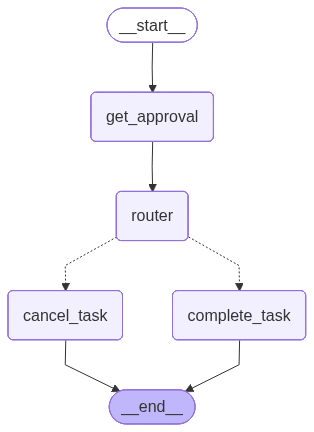

In [17]:
################################ 3. Graph Construction ################################

# Initialize an in-memory checkpointer. This is required for 'interrupt' to work,
# as it needs to save the graph's state when it pauses.
memory = InMemorySaver()

# Create the graph builder.
builder = StateGraph(WorkflowState)

# Add the functions as nodes to the graph.
builder.add_node('get_approval', get_approval)
builder.add_node('router', router)
builder.add_node('complete_task', complete_task)
builder.add_node('cancel_task', cancel_task)

# Define the graph's structure (its edges).
builder.add_edge(START, 'get_approval')
builder.add_edge('get_approval', 'router')
# Add conditional edges from the router node. 
builder.add_conditional_edges(
    'router',
    router,  # Your router function, which would return the next node name as a string (e.g., 'complete_task' or 'cancel_task')
    {'complete_task': 'complete_task', 'cancel_task': 'cancel_task'}  # Map of possible returns to nodes
)
# NOTE: We do NOT need to add conditional edges from the 'router' node.
# The 'Command' object returned by the router handles the routing dynamically.

builder.add_edge('complete_task', END)
builder.add_edge('cancel_task', END)

# Compile the graph, enabling the checkpointer.
graph = builder.compile(checkpointer=memory)

# The complete_task and cancel_task nodes appear disconnected in the visualization because their connection to the graph is dynamic, not static. The routing decision is made at runtime by the router node using the Command object.

# You can visualize the graph structure.
# Notice the router doesn't have explicit paths leading out of it.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    # print(graph.get_graph().draw_mermaid())
except Exception as e:
    print(f'Could not display graph: {e}')

## Workflow Execution - Approval Scenario

Let's test our workflow with both approval and rejection scenarios. Each run uses a separate thread to maintain independent state.

### Run 1: Approving the Task
This demonstrates the complete approval workflow:

In [18]:
########################## 4. Graph Execution & Interaction ##########################

# --- Run 1: Approve the task ---
print('\n' + '=' * 50 + '\n🚀 STARTING RUN 1: APPROVAL\n' + '=' * 50)

# A 'thread_id' is needed to track the state of a single run.
thread = {'configurable': {'thread_id': 'run-1'}}
initial_task = {'task': 'Deploy new feature to production'}

# Start the graph. It will run until it hits the 'interrupt' in the 'get_approval' node.
# We use 'stream' to see the events as they happen.
for event in graph.stream(initial_task, thread, stream_mode='values'):
    print(f'\n[STREAM EVENT]:\n{event}\n')

# At this point, the graph is paused. Let's resume it with the user's decision.
# For conditional edges approach, we update the state with the interrupt value
print("\n... Resuming Run 1 with 'approve' ...\n")
graph.update_state(thread, {'user_decision': 'approve'})
for event in graph.stream(None, thread, stream_mode='values'):
    print(f'\n[STREAM EVENT]:\n{event}\n')

==================================================
🚀 STARTING RUN 1: APPROVAL
==================================================

[STREAM EVENT]:
{'task': 'Deploy new feature to production'}

--- ⏸️ PAUSING FOR APPROVAL ---

Task: 'Deploy new feature to production'

... Resuming Run 1 with 'approve' ...

[STREAM EVENT]:
{'task': 'Deploy new feature to production', 'user_decision': 'approve'}

--- ⏸️ PAUSING FOR APPROVAL ---

Task: 'Deploy new feature to production'

## Workflow Execution - Rejection Scenario

### Run 2: Rejecting the Task
This demonstrates the rejection workflow path:

In [22]:
# --- Run 2: Reject the task ---
print('\n' + '=' * 50 + '\n🚀 STARTING RUN 2: REJECTION\n' + '=' * 50)

# Use a new thread_id for the second, independent run.
thread2 = {'configurable': {'thread_id': 'run-2'}}

# Start the second run.
for event in graph.stream(initial_task, thread2, stream_mode='values'):
    print(f'\n[STREAM EVENT]:\n{event}\n')

# Resume the second run, but this time with a 'reject' decision.
print("\n... Resuming Run 2 with 'reject' ...\n")
graph.update_state(thread2, {'user_decision': 'reject'})
for event in graph.stream(None, thread2, stream_mode='values'):
    print(f'\n[STREAM EVENT]:\n{event}\n')

==================================================
🚀 STARTING RUN 2: REJECTION
==================================================

[STREAM EVENT]:
{'task': 'Deploy new feature to production', 'user_decision': 'reject'}

--- ⏸️ PAUSING FOR APPROVAL ---

Task: 'Deploy new feature to production'

... Resuming Run 2 with 'reject' ...

[STREAM EVENT]:
{'task': 'Deploy new feature to production', 'user_decision': 'reject'}

--- ⏸️ PAUSING FOR APPROVAL ---

Task: 'Deploy new feature to production'